In [217]:
import scipy as sci
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, CubicSpline
from matplotlib.gridspec import GridSpec as GS
from numpy import linalg as LA 
from scipy.integrate import odeint, solve_ivp

In [218]:
def func(t, m,h,gamma,alpha):
     dm=-gamma*(np.cross(m,h)-alpha*np.cross(m,-gamma*np.cross(m,h)))
     
     return dm

In [219]:
def rad(xyz):
    ptsnew = np.zeros([len(xyz),3])
    xy = xyz[:,0]**2 + xyz[:,1]**2
    ptsnew[:,0] = np.sqrt(xy + xyz[:,2]**2)
    ptsnew[:,1] = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down
#     ptsnew[:,1] = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    ptsnew[:,2] = np.arctan2(xyz[:,1], xyz[:,0])
    return ptsnew

In [345]:
m=[0,np.sin(10*np.pi/180),np.cos(10*np.pi/180)] #inital magentisation
gamma=-1.760  #*10^11 for actual value

alpha=0.1

h=(0,0,-1)
p=(h,gamma,alpha)
t = np.arange(0.0, 35,0.01)
result_odeintz = odeint(func, m, t,p, tfirst=True)
rad1=rad(result_odeintz)

In [346]:
m

[0, 0.17364817766693033, 0.984807753012208]

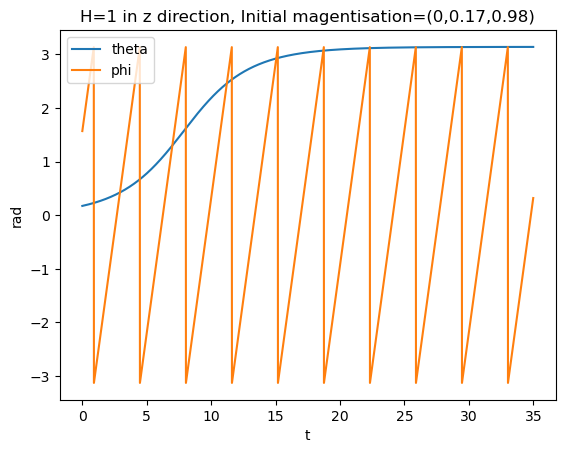

In [347]:
fig = plt.figure()
# plt.plot(t,rad1[:,0], label='r')
plt.plot(t,rad1[:,1], label='theta')
plt.plot(t,rad1[:,2], label='phi')

plt.xlabel("t")
plt.ylabel("rad")
plt.title("H=1 in z direction, Initial magentisation=(0,0.17,0.98)")
plt.legend()
plt.show()

Text(0.5, 0.92, 'Magnetisation for 0D single spin')

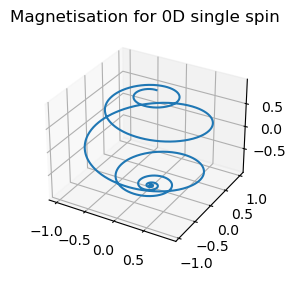

In [223]:
fig=plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot(result_odeintz[:, 0],
        result_odeintz[:, 1],
        result_odeintz[:, 2])
ax.set_title("Magnetisation for 0D single spin")

In [224]:
def dot(pol,t):
    udot=np.zeros(len(pol))
    for i in list(range(len(pol)-1)):
        k=np.array([pol[i+1]-pol[i]-2*np.pi,pol[i+1]-pol[i],pol[i+1]-pol[i]+2*np.pi])
        ind=np.where(np.abs(k)==(min(np.abs(k))))
        udot[i]=(k[ind]/(t[i+1]-t[i]))[0]
    k=np.array([pol[-1]-pol[-2]-2*np.pi,pol[-1]-pol[-2],pol[-1]-pol[-2]+2*np.pi])
    ind=np.where(np.abs(k)==(min(np.abs(k))))
    udot[-1]=(k[ind]/(t[-1]-t[-2]))[0]
    return udot
def conv(ang):
    l=len(ang)
    ang=ang%(2*np.pi)
    for i in range(l):
        if(ang[i]>np.pi):
            ang[i]=ang[i]-2*np.pi
    return ang     

In [225]:
udot=np.stack((dot(rad1[:,1],t),dot(rad1[:,2],t)),axis=-1)
udot=np.array(udot)

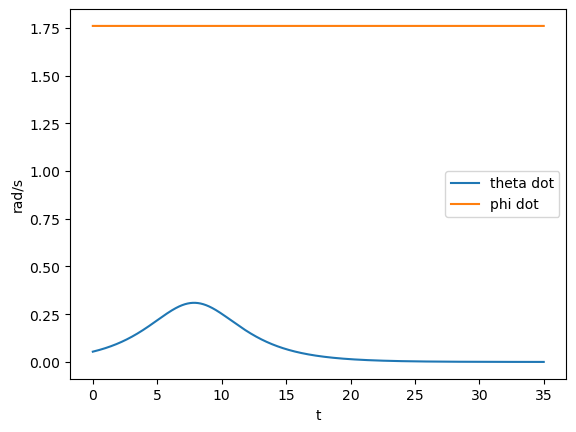

In [226]:
fig = plt.figure()
plt.plot(t,udot[:,0], label='theta dot')
plt.plot(t,udot[:,1], label='phi dot')
plt.xlabel("t")
plt.ylabel("rad/s")
plt.legend()
plt.show()

In [227]:
library_functions = [lambda x: np.cos(x),lambda x: np.sin(x),lambda x: np.sin(x)*np.cos(x), lambda : 1]
library_function_names = [lambda x: "cos(" + x +")", lambda x: "sin(" + x + ")",lambda x: "Sin("+ x +")*Cos("+x+")", lambda: ""]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    )
modelpol = ps.SINDy(feature_library=pde_lib,feature_names=["theta","phi"])
modelpol.fit(rad1[:,-2:],x_dot=udot)
modelpol.print()

(theta)' = 0.310 sin(theta)
(phi)' = 1.760 


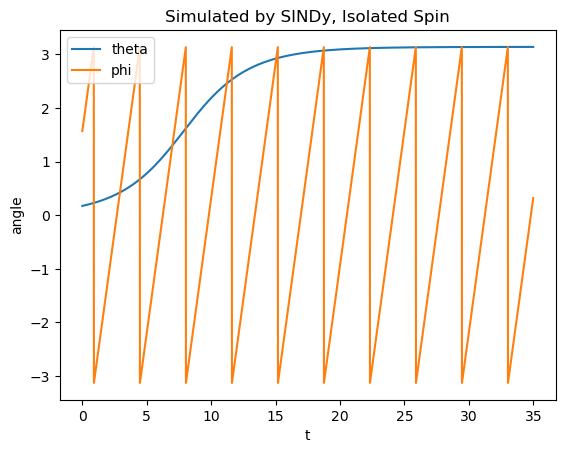

In [228]:
simpol=modelpol.simulate(rad1[0,-2:],t,integrator='odeint')
phi=conv(simpol[:,1])
simpol[:,1]=phi
fig = plt.figure()

plt.plot(t,simpol[:,0], label='theta')
plt.plot(t,simpol[:,1], label='phi')

plt.xlabel("t")
plt.ylabel("angle")
plt.title("Simulated by SINDy, Isolated Spin")
plt.legend()
plt.show()

In [325]:
import math

def polar2cart(r, theta, phi):
    return [
         r * math.sin(theta) * math.cos(phi),
         r * math.sin(theta) * math.sin(phi),
         r * math.cos(theta)
    ]

In [331]:
sim3d=np.zeros((len(simpol),3))

In [338]:
for i in range(len(simpol)):
    sim3d[i]=polar2cart(1,simpol[i,0],simpol[i,1])
    

In [337]:
len(sim3d)

3500

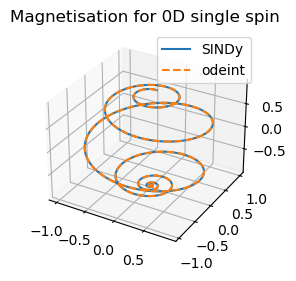

In [342]:


fig=plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot(sim3d[:, 0],
        sim3d[:, 1],
        sim3d[:, 2],label="SINDy")

ax.plot(result_odeintz[:, 0],
        result_odeintz[:, 1],
        result_odeintz[:, 2],label='odeint', linestyle='dashed')
ax.set_title("Magnetisation for 0D single spin")
ax.legend()
plt.show()


In [230]:
def timepr(alpha,thr):
    m=[0,np.sin(10*np.pi/180),np.cos(10*np.pi/180)] #inital magentisation 
    gamma=-1.760  #*10^11 for actual value
    
    h=(0,0,-1)
    p=(h,gamma,alpha)
    t = np.arange(0.0, 200,0.01)
    result_odeintz = odeint(func, m, t,p, tfirst=True)
    for i in range(20000):
        if (result_odeintz[i,2]<=thr):
            return t[i]
    return(201)

In [231]:
from joblib import Parallel, delayed
al=np.arange(0.04,0.8,0.02)
timeal = Parallel(n_jobs=6)(delayed(timepr)(a,np.cos(np.pi*170/180)) for a in al)


In [232]:
np.cos(np.pi*170/180)

-0.984807753012208

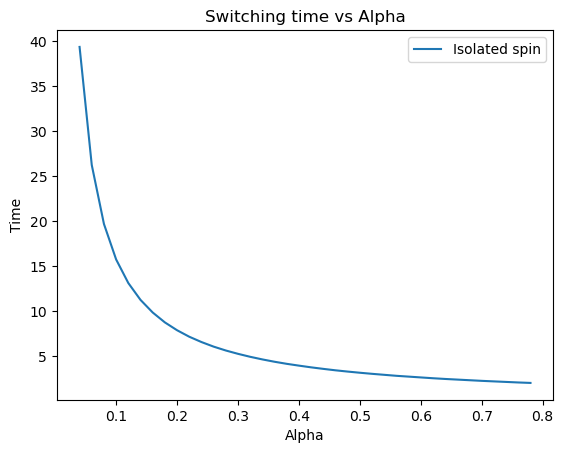

In [233]:
plt.plot(al,timeal, label='Isolated spin')
plt.xlabel("Alpha")
plt.ylabel("Time")
plt.title("Switching time vs Alpha")

plt.legend()
plt.show()


In [239]:
def timet(lis,t,thr):
    r=len(lis)
    for i in range(r):
        if (lis[i]>=thr):
            return t[i]
    return(t[-1])
def timeprsim(alph,thr):
    m=[0,np.sin(10*np.pi/180),np.cos(10*np.pi/180)] 
    gamma=-1.760  #*10^11 for actual value
    h=(0,0,-1)
    p=(h,gamma,alph)
    t = np.arange(0.0, 200,0.01)
    result_odeintz = odeint(func, m, t,p, tfirst=True)
    rad1=rad(result_odeintz)
    udot=np.stack((dot(rad1[:,1],t),dot(rad1[:,2],t)),axis=-1)
    udot=np.array(udot)
    library_functions = [lambda x: np.cos(x),lambda x: np.sin(x),lambda x: np.sin(x)*np.cos(x), lambda : 1]
    library_function_names = [lambda x: "cos(" + x +")", lambda x: "sin(" + x + ")",lambda x: "Sin("+ x +")*Cos("+x+")", lambda: ""]
    pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    )
    modelpol = ps.SINDy(feature_library=pde_lib,feature_names=["theta","phi"])
    modelpol.fit(rad1[:,-2:],x_dot=udot)
    simpol=modelpol.simulate(rad1[0,-2:],t,integrator='odeint')
    phi=conv(simpol[:,1])
    return timet(simpol[:,0],t,thr)
def tau(th1,th2,alpha):
    t=np.abs((((alpha**2)+1)/(gamma*alpha))*(1/LA.norm(h)**2)*(LA.norm(h)*np.log(np.tan(th2/2)/np.tan(th1/2))))   #H_k=0
    return t   
    
    

In [240]:
np.abs(tau(np.pi*10/180,np.pi*170/180,0.2))

14.395999408321094

In [241]:
from joblib import Parallel, delayed
alsim=np.arange(0.04,0.8,0.02)
timealsim = Parallel(n_jobs=12)(delayed(timeprsim)(a,np.pi*170/180) for a in al)
altau=Parallel(n_jobs=12)(delayed(tau)(np.pi*10/180,np.pi*170/180,a) for a in al)

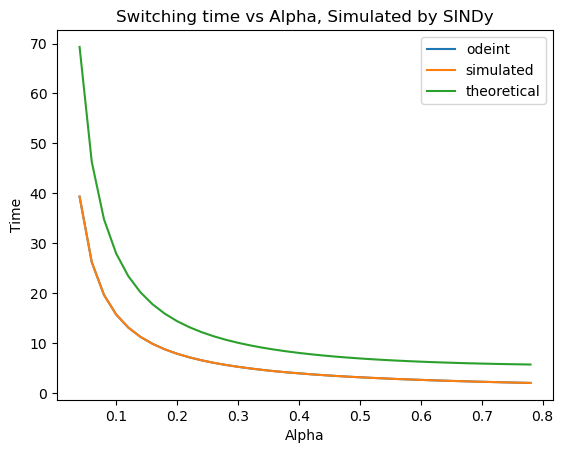

In [290]:
plt.plot(al,timeal, label='odeint')
plt.plot(alsim,timealsim, label='simulated')
plt.plot(alsim,altau, label='theoretical')

plt.xlabel("Alpha")
plt.ylabel("Time")
plt.title("Switching time vs Alpha, Simulated by SINDy")

plt.legend()
plt.show()


In [308]:
def ans(alpha):
    m=[0,np.sin(10*np.pi/180),np.cos(10*np.pi/180)] #inital magentisation
    gamma=-1.760  #*10^11 for actual value
    h=(0,0,-1)
    p=(h,gamma,alpha)
    t = np.arange(0.0,min(tau(np.pi*10/180,np.pi*170/180,alpha)*1.2,50),0.01)
    result_odeintz = odeint(func, m, t,p, tfirst=True)
    rad1=rad(result_odeintz)
    udot=np.stack((dot(rad1[:,1],t),dot(rad1[:,2],t)),axis=-1)
    udot=np.array(udot)
    thres=alpha
    library_functions = [lambda x: np.cos(x),lambda x: np.sin(x),lambda x: np.sin(x)*np.cos(x), lambda : 1]
    library_function_names = [lambda x: "cos(" + x +")", lambda x: "sin(" + x + ")",lambda x: "Sin("+ x +")*Cos("+x+")", lambda: ""]
    pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    )
    modelpol = ps.SINDy(feature_library=pde_lib,feature_names=["theta","phi"],optimizer=ps.STLSQ(threshold=min(thres,0.1)))
    modelpol.fit(rad1[:,-2:],x_dot=udot)
    simpol=modelpol.simulate(rad1[0,-2:],t,integrator='odeint')
    phi=conv(simpol[:,1])
    simpol[:,1]=phi
#     rms=LA.norm((rad1[:,-2:]-simpol))/len(simpol)**0.5
    rms = np.sqrt(np.mean((rad1[:,-2:]-simpol)**2))
    return (rad1[:,-2:],simpol)
def err(alpha):
    an=ans(alpha)
    rms = np.sqrt(np.mean((an[0]-an[1])**2))
    return rms

In [298]:
rad1[:,-2:]-simpol

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 8.61352489e-10, -4.72571535e-08],
       [ 1.32298842e-08,  8.57447757e-09],
       ...,
       [ 4.00539402e-08,  3.44952872e-07],
       [ 3.98797342e-08,  2.37535792e-07],
       [ 3.97016175e-08,  1.18767890e-07]])

In [273]:
len(ans(0.5)[0][:,0])

831

In [309]:
from joblib import Parallel, delayed
alplist=np.arange(0.01,0.8,0.01)

alp=Parallel(n_jobs=6)(delayed(err)(a) for a in alplist)

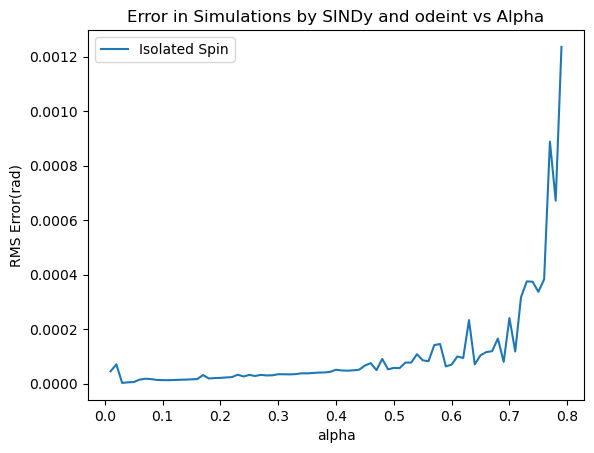

In [310]:
plt.plot(alplist,alp, label='Isolated Spin')

plt.xlabel("alpha")
plt.ylabel("RMS Error(rad)")
plt.title("Error in Simulations by SINDy and odeint vs Alpha")
plt.legend()
plt.show()

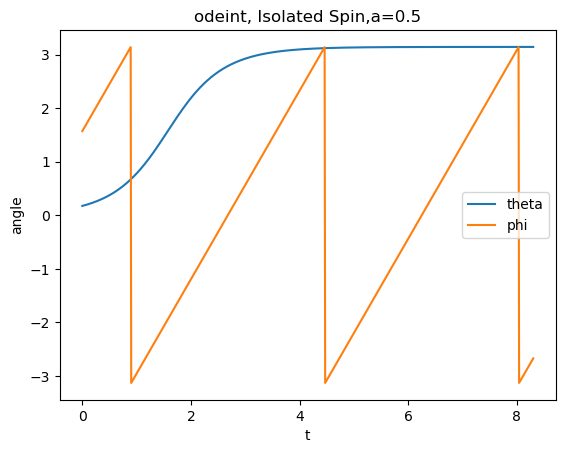

In [311]:
fig = plt.figure()
td=np.arange(0.0,min(tau(np.pi*10/180,np.pi*170/180,0.5)*1.2,50),0.01)
plt.plot(td,ans(0.5)[0][:,0], label='theta')
plt.plot(td,ans(0.5)[0][:,1], label='phi')

plt.xlabel("t")
plt.ylabel("angle")
plt.title("odeint, Isolated Spin,a=0.5")
plt.legend()
plt.show()

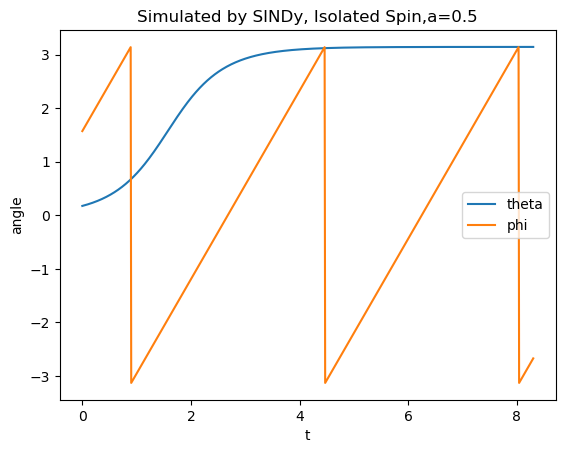

In [312]:
fig = plt.figure()
td=np.arange(0.0,min(tau(np.pi*10/180,np.pi*170/180,0.5)*1.2,50),0.01)
plt.plot(td,ans(0.5)[1][:,0], label='theta')
plt.plot(td,ans(0.5)[1][:,1], label='phi')

plt.xlabel("t")
plt.ylabel("angle")
plt.title("Simulated by SINDy, Isolated Spin,a=0.5")
plt.legend()
plt.show()

In [300]:
len(ans(0.02)[0])
err(0.02)

7.014399955298207e-05

# Spherical Geometry

In [319]:
def funcsph(t, m,h,gamma,alpha):
    demag=np.array([1/3,1/3,1/3])
    h=np.subtract(h,np.dot(demag,m))
    dm=-gamma*(np.cross(m,h)-alpha*np.cross(m,-gamma*np.cross(m,h)))
     
    return dm

In [320]:
m=[0,np.sin(10*np.pi/180),np.cos(10*np.pi/180)] #inital magentisation 
gamma=-1.760  #*10^11 for actual value

alpha=0.06

h=(0,0,-1)
p=(h,gamma,alpha)
t = np.arange(0.0, 20,0.01)
result_sph = odeint(funcsph, m, t,p, tfirst=True)
rad1sph=rad(result_sph)

0.984807753012208

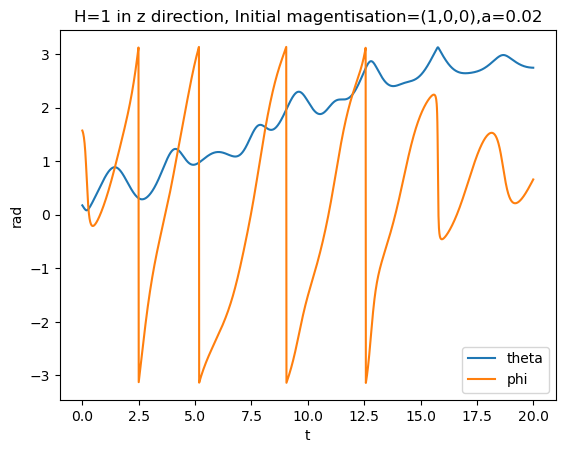

In [321]:
fig = plt.figure()
# plt.plot(t,rad1[:,0], label='r')
plt.plot(t,rad1sph[:,1], label='theta')
plt.plot(t,rad1sph[:,2], label='phi')

plt.xlabel("t")
plt.ylabel("rad")
plt.title("H=1 in z direction, Initial magentisation=(1,0,0),a=0.02")
plt.legend()
plt.show()

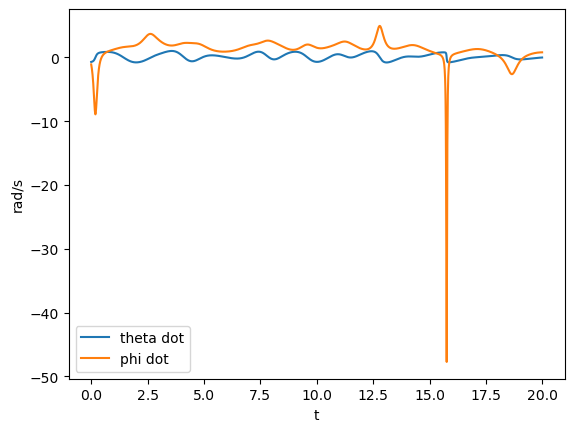

In [322]:
udotsph=np.stack((dot(rad1sph[:,1],t),dot(rad1sph[:,2],t)),axis=-1)
udotsph=np.array(udotsph)
fig = plt.figure()
plt.plot(t,udotsph[:,0], label='theta dot')
plt.plot(t,udotsph[:,1], label='phi dot')
plt.xlabel("t")
plt.ylabel("rad/s")
plt.legend()
plt.show()

In [323]:
library_functions = [lambda x: np.cos(x),lambda x: np.sin(x),lambda x: np.sin(x)*np.cos(x), lambda : 1]
library_function_names = [lambda x: "cos(" + x +")", lambda x: "sin(" + x + ")",lambda x: "Sin("+ x +")*Cos("+x+")", lambda: ""]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    )
modelpolsph = ps.SINDy(feature_library=pde_lib,feature_names=["theta","phi"],optimizer=ps.STLSQ(threshold=0.01))
modelpolsph.fit(rad1sph[:,-2:],x_dot=udotsph)
modelpolsph.print()

(theta)' = 0.155 cos(theta) + -0.033 cos(phi) + 0.134 sin(theta) + 0.068 sin(phi) + -0.188 Sin(theta)*Cos(theta) + -0.043 Sin(phi)*Cos(phi) + 0.059 
(phi)' = 0.910 cos(theta) + -0.238 cos(phi) + 2.941 sin(theta) + -0.360 sin(phi) + -1.827 Sin(theta)*Cos(theta) + -0.063 Sin(phi)*Cos(phi) + -0.471 


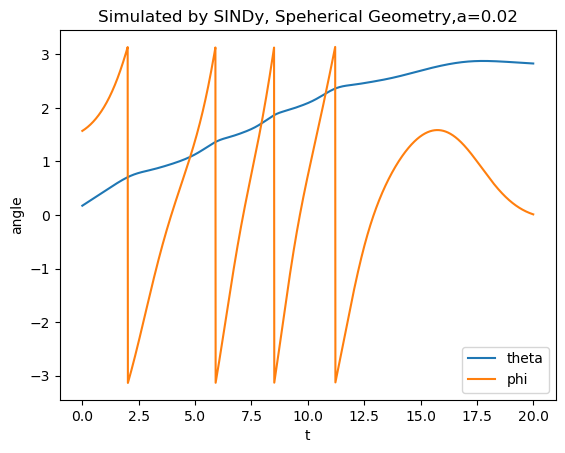

In [324]:
simpolsph=modelpolsph.simulate(rad1sph[0,-2:],t,integrator='odeint')
phisph=conv(simpolsph[:,1])



fig = plt.figure()

plt.plot(t,simpolsph[:,0], label='theta')
plt.plot(t,phisph, label='phi')

plt.xlabel("t")
plt.ylabel("angle")
plt.title("Simulated by SINDy, Speherical Geometry,a=0.02")
plt.legend()
plt.show()